# Analysing Carbon Plan data in terms of variability

Now that we've extracted some of the carbon plan predictions from their downscaling products, let's see what we can do with them. The aim of this is to use our csv files to plot some histograms of summertime max air temperatures over our chosen location. This should hopefully start us thinking about changes in the weather over our location.

First step is to import some relevant libraries. Here I'm using pandas, xarray and matplotlib.

In [109]:
import pandas as pd
import xarray as xar
import matplotlib.pyplot as plt

Now I'm going to read in the csv files I've made with my other script. These are just two examples, so you'll have to change the file names for ones that are relevant to you. I'm reading in the historical period and a future period so that I can compare them.

In [110]:
future_experiment_name='ssp585'


historical_df = pd.read_csv('./CMIP.MIROC.MIROC6.historical.day.GARD-SV_50.73_-3.53_JJA.csv', parse_dates=['time'])
future_df     = pd.read_csv('./ScenarioMIP.MIROC.MIROC6.ssp585.day.GARD-SV_50.73_-3.53_JJA.csv', parse_dates=['time'])

I'm now converting these to xarray datasets, as I find these easier to work with than pandas dataframes:

In [111]:
historical_ds = historical_df.to_xarray()
future_ds = future_df.to_xarray()

To do some of the operations I'd like to do in terms of times I'm making time the variable's dimension.

In [112]:
historical_ds.coords['time'] = historical_ds['time']
historical_ds['tasmax'] = ('time', historical_ds['tasmax'].values)

future_ds.coords['time'] = future_ds['time']
future_ds['tasmax'] = ('time', future_ds['tasmax'].values)

When we think about the 'climate', we often want to average over multiple years to get rid of the noisy weather and find the climate 'signal' behind it. To do that here I'm going to make some averages for every day of the year (here labeled as `dayofyear`. I'm also calculating the standard deviation about that mean.

In [113]:
historical_ds.coords['dayofyear'] = ('time', historical_ds['time'].dt.dayofyear.values)
historical_day_climatology = historical_ds['tasmax'].groupby('dayofyear').mean('time')
historical_day_std = historical_ds['tasmax'].groupby('dayofyear').std('time')


future_ds.coords['dayofyear'] = ('time', future_ds['time'].dt.dayofyear.values)
future_day_climatology = future_ds['tasmax'].groupby('dayofyear').mean('time')
future_day_std = future_ds['tasmax'].groupby('dayofyear').std('time')

Again, to try and understand the variability, I'm looking at one standard deviation either side of the mean

In [114]:
historical_day_climatology_p1sd = historical_day_climatology+historical_day_std
historical_day_climatology_m1sd = historical_day_climatology-historical_day_std

future_day_climatology_p1sd = future_day_climatology+future_day_std
future_day_climatology_m1sd = future_day_climatology-future_day_std

Now I'm going to plot my climate for this location for the historical and future periods, and shade the region of one standard deviation either side of that mean.

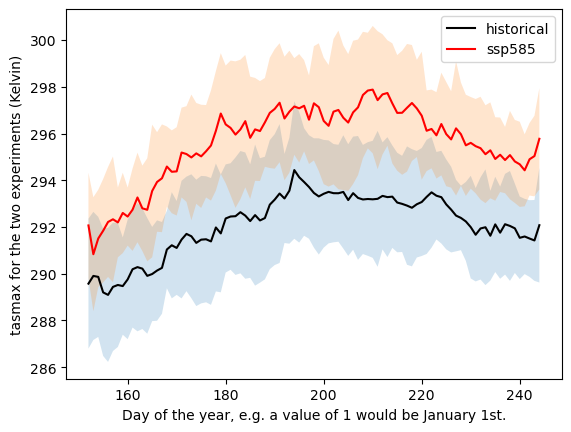

In [117]:
plt.plot(historical_day_climatology['dayofyear'], historical_day_climatology.values, label='historical', color='k')
plt.fill_between(historical_day_climatology['dayofyear'], historical_day_climatology_m1sd, historical_day_climatology_p1sd, alpha=0.2)

plt.plot(future_day_climatology['dayofyear'], future_day_climatology.values, label=future_experiment_name, color='r')
plt.fill_between(future_day_climatology['dayofyear'], future_day_climatology_m1sd, future_day_climatology_p1sd, alpha=0.2)

plt.xlabel('Day of the year, e.g. a value of 1 would be January 1st.')
plt.ylabel('tasmax for the two experiments (Kelvin)')

plt.legend()

This is useful, of course. But I'd also like an idea of how the probability of high temperatures has changed. For this I'm going to turn the historical and future temperature data into histograms and plot them on top of one another for comparison. I am free to choose the number of bins, of course.

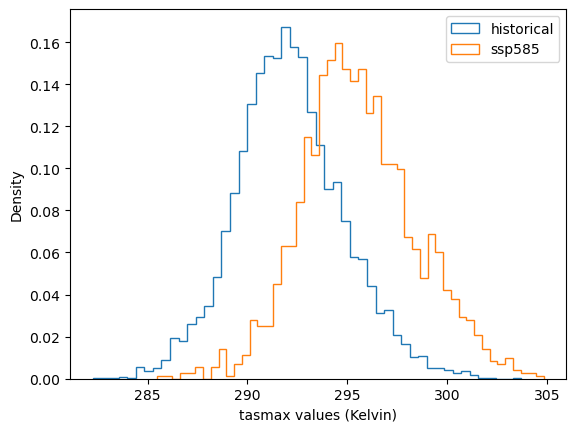

In [119]:
binnumber = 50

plt.hist(historical_ds['tasmax'].values, bins=binnumber, density=True, histtype='step', label='historical')
plt.hist(future_ds['tasmax'].values, bins=binnumber, density=True, histtype='step', label=future_experiment_name)
plt.xlabel('tasmax values (Kelvin)')
plt.ylabel('Density')
plt.legend()

In the above example we can see clearly that the end of the century under ssp585 will result in significant warming of the mean temperature, and a significant increase in the number of days above 300K. If you make such plots for your locations, and also factor in thresholds for heat stess etc, you can calculate the number of days that are now over a heat stroke threshold compared with the historical period.